In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from surprise import SVD, Dataset, Reader
from surprise.model_selection import train_test_split
from surprise import accuracy

### The Data

In [2]:
genome_scores = pd.read_csv("data/genome_scores.csv")
genome_tags = pd.read_csv("data/genome_tags.csv")

# Small Dataset
links = pd.read_csv("data/links.csv")
movies = pd.read_csv("data/movies.csv")
ratings = pd.read_csv("data/ratings.csv")
tags = pd.read_csv("data/tags.csv")

#### Some helper functions

In [3]:
# col_list function
def col_list(x):
    return list(x.columns.values.tolist())

# count blanks function
def count_blanks(df):
    x = col_list(df)
    rows = df.shape[0]
    for i in x:
        c = (df[i].isna()).sum()
        print(f"The column, {i}, has {c} blanks out of {rows:,} rows ({c/rows:.1%}).")

<a id='eda'></a>
# EDA

### **Genome Scores**


In [4]:
genome_scores.head()

,movieId,tagId,relevance
0,1,1,0.02500
1,1,2,0.02500
2,1,3,0.05775
3,1,4,0.09675
4,1,5,0.14675


In [5]:
genome_scores.describe()['relevance']

count    1.170977e+07
mean     1.164833e-01
std      1.542463e-01
min      2.500000e-04
25%      2.425000e-02
50%      5.650000e-02
75%      1.415000e-01
max      1.000000e+00
Name: relevance, dtype: float64

In [6]:
count_blanks(genome_scores)

The column, movieId, has 0 blanks out of 11,709,768 rows (0.0%).
The column, tagId, has 0 blanks out of 11,709,768 rows (0.0%).
The column, relevance, has 0 blanks out of 11,709,768 rows (0.0%).


In [7]:
genome_scores.dtypes

movieId        int64
tagId          int64
relevance    float64
dtype: object

### Genome Tags

In [8]:
genome_tags.head()

,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s


In [9]:
count_blanks(genome_scores)

The column, movieId, has 0 blanks out of 11,709,768 rows (0.0%).
The column, tagId, has 0 blanks out of 11,709,768 rows (0.0%).
The column, relevance, has 0 blanks out of 11,709,768 rows (0.0%).


### Tags


In [10]:
tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [11]:
tags.dtypes

userId        int64
movieId       int64
tag          object
timestamp     int64
dtype: object

In [12]:
tags.tag.value_counts()

tag
In Netflix queue     131
atmospheric           36
thought-provoking     24
superhero             24
funny                 23
                    ... 
small towns            1
In Your Eyes           1
Lloyd Dobbler          1
weak plot              1
Heroic Bloodshed       1
Name: count, Length: 1589, dtype: int64

In [13]:
count_blanks(tags)

The column, userId, has 0 blanks out of 3,683 rows (0.0%).
The column, movieId, has 0 blanks out of 3,683 rows (0.0%).
The column, tag, has 0 blanks out of 3,683 rows (0.0%).
The column, timestamp, has 0 blanks out of 3,683 rows (0.0%).


### Ratings


In [14]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [15]:
ratings.dtypes

userId         int64
movieId        int64
rating       float64
timestamp      int64
dtype: object

In [16]:
count_blanks(ratings)

The column, userId, has 0 blanks out of 100,836 rows (0.0%).
The column, movieId, has 0 blanks out of 100,836 rows (0.0%).
The column, rating, has 0 blanks out of 100,836 rows (0.0%).
The column, timestamp, has 0 blanks out of 100,836 rows (0.0%).


In [17]:
unique_users = (ratings.userId.unique())
print(f"{unique_users.size:,} total users")

610 total users


In [18]:
users = ratings.groupby(['userId'])['userId'].count()
print(f"{users.mean():.1f} avg ratings by user")
print(f"{users.median():.1f} avg ratings by user")

165.3 avg ratings by user
70.5 avg ratings by user


In [19]:
aggregated_ratings = ratings.groupby('userId') \
       .agg({'movieId':'count', 'rating':'mean'}) \
       .rename(columns={'movieId':'no_of_ratings','rating':'mean_rating'}) \
       .reset_index()
aggregated_ratings.head()

,userId,no_of_ratings,mean_rating
0,1,232,4.366379
1,2,29,3.948276
2,3,39,2.435897
3,4,216,3.555556
4,5,44,3.636364


In [20]:
aggregated_ratings.no_of_ratings.describe()

count     610.000000
mean      165.304918
std       269.480584
min        20.000000
25%        35.000000
50%        70.500000
75%       168.000000
max      2698.000000
Name: no_of_ratings, dtype: float64

In [21]:
from datetime import datetime
ratings['date'] = pd.to_datetime(ratings['timestamp'], unit='s')

user_lifetime = ratings.groupby('userId') \
       .agg({'date': ['min', 'max']}) \
       .reset_index()
user_lifetime.columns = user_lifetime.columns.map('_'.join).str.strip('_')
user_lifetime['user_days'] = (user_lifetime['date_max'] - user_lifetime['date_min']).dt.total_seconds() / 86_400
user_lifetime = user_lifetime.loc[user_lifetime['user_days'] > 1]
user_lifetime.head()

,userId,date_min,date_max,user_days
0,1,2000-07-30 18:08:19,2000-08-08 07:27:42,8.555127
3,4,1999-12-13 09:47:08,2001-12-05 17:49:02,723.334653
6,7,2005-01-25 06:43:36,2007-04-10 05:08:51,804.934201
9,10,2016-02-12 18:25:53,2016-02-16 10:41:15,3.677338
10,11,1998-07-23 13:20:37,1998-08-30 20:56:07,38.316319


<Axes: xlabel='user_days', ylabel='Count'>

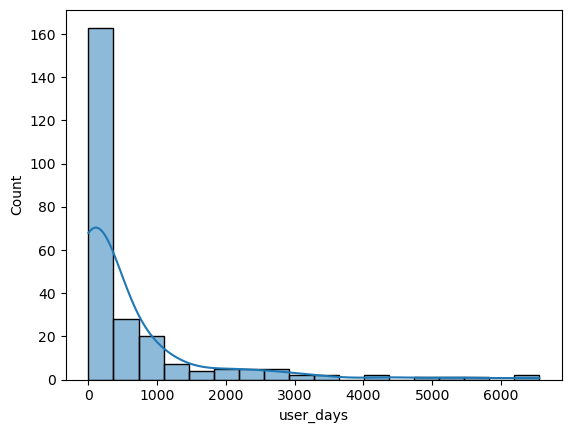

In [22]:
sns.histplot(data=user_lifetime, x="user_days", kde=True, stat='count', binwidth=365)

In [23]:
processed_ratings = movies[['movieId','title']].merge(ratings, on='movieId', how='outer')
processed_ratings = processed_ratings[['title','userId','rating']]
processed_ratings.head()

,title,userId,rating
0,Toy Story (1995),1.0,4.0
1,Toy Story (1995),5.0,4.0
2,Toy Story (1995),7.0,4.5
3,Toy Story (1995),15.0,2.5
4,Toy Story (1995),17.0,4.5


[Text(0.5, 1.0, 'Rating Counts by Year')]

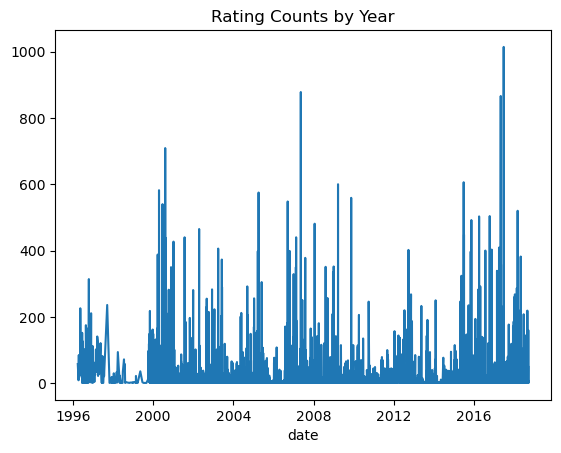

In [24]:
from datetime import datetime
ratings['date'] = pd.to_datetime(ratings['timestamp'], unit='s').dt.date
ratings.date.value_counts().plot(kind='line').set(title='Rating Counts by Year')

### Links

In [25]:
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


<Axes: >

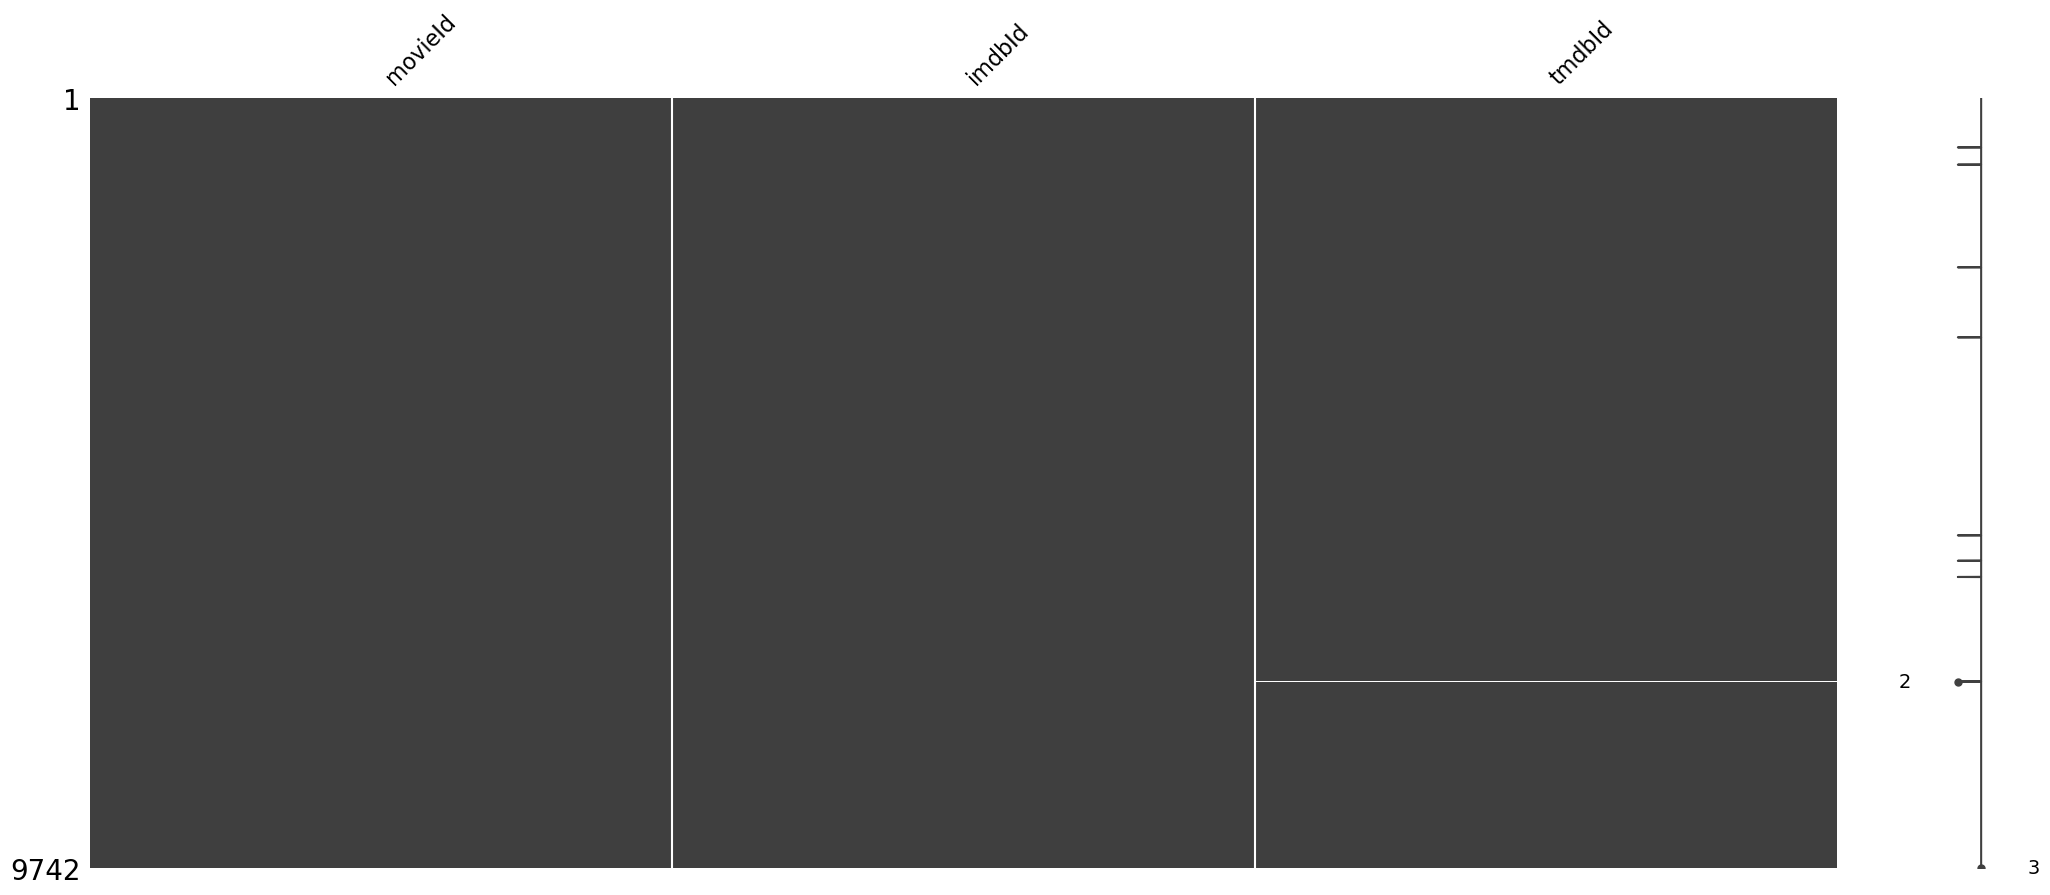

In [26]:
msno.matrix(links)

In [27]:
count_blanks(links)

The column, movieId, has 0 blanks out of 9,742 rows (0.0%).
The column, imdbId, has 0 blanks out of 9,742 rows (0.0%).
The column, tmdbId, has 8 blanks out of 9,742 rows (0.1%).


### Movies


In [28]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [29]:
movies.shape

(9742, 3)

In [31]:
movie_ratings = movies.merge(ratings, on='movieId')
movie_ratings = movie_ratings[['movieId','title','genres','userId','rating']]
movie_ratings.head()

,movieId,title,genres,userId,rating
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1,4.0
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,7,4.5
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,15,2.5
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,17,4.5


In [32]:
cleaned_movies = movies.assign(genres=movies['genres'].str.split('|')).explode('genres')
cleaned_movies['year_released'] = cleaned_movies['title'].str.extract(r'\((\d{4})\)')
cleaned_movies['year_released'] = pd.to_numeric(cleaned_movies['year_released'], errors='coerce')
cleaned_movies = links.merge(cleaned_movies, on='movieId', how='outer')
cleaned_movies = cleaned_movies[['imdbId', 'title','year_released', 'genres']]
cleaned_movies.set_index('imdbId', inplace=True)
cleaned_movies.head()

,title,year_released,genres
imdbId,,,
114709,Toy Story (1995),1995.0,Adventure
114709,Toy Story (1995),1995.0,Animation
114709,Toy Story (1995),1995.0,Children
114709,Toy Story (1995),1995.0,Comedy
114709,Toy Story (1995),1995.0,Fantasy


[Text(0.5, 1.0, 'Movies by Year')]

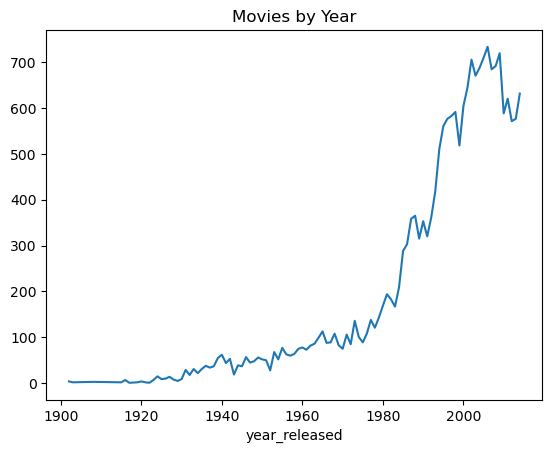

In [33]:
movie_years = cleaned_movies[['title','year_released']]
movie_years = movie_years[(movie_years['year_released'] > 0) & (movie_years['year_released'] < 2015)]
movie_years.year_released.value_counts().sort_index(ascending=True).plot(kind='line').set(title="Movies by Year")

In [34]:
one_hot = pd.get_dummies(cleaned_movies['genres'], dtype=float)
cleaned_movies = cleaned_movies.drop('genres',axis = 1)
cleaned_movies = cleaned_movies.join(one_hot)
cleaned_movies = cleaned_movies.groupby(['title']).max()
cleaned_movies.head()

,year_released,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,...,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
title,,,,,,,,,,,,,,,,,,,,,
'71 (2014),2014.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
'Hellboy': The Seeds of Creation (2004),2004.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
'Round Midnight (1986),1986.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
'Salem's Lot (2004),2004.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
'Til There Was You (1997),1997.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [35]:
movie_tags = movies.merge(genome_scores, on='movieId', how='outer').merge(genome_tags, on='tagId', how='outer')[['title','relevance','tag']]
movie_tags.head()

,title,relevance,tag
0,Toy Story (1995),0.02500,007
1,Jumanji (1995),0.03975,007
2,Grumpier Old Men (1995),0.04350,007
3,Waiting to Exhale (1995),0.03725,007
4,Father of the Bride Part II (1995),0.04200,007


In [36]:
pivoted_movie_tags = movie_tags.pivot_table(index='title', columns='tag', values='relevance')
pivoted_movie_tags.head()

tag,007,007 (series),18th century,1920s,1930s,1950s,1960s,1970s,1980s,19th century,...,world politics,world war i,world war ii,writer's life,writers,writing,wuxia,wwii,zombie,zombies
title,,,,,,,,,,,,,,,,,,,,,
'71 (2014),0.01350,0.01250,0.04650,0.05525,0.11375,0.04425,0.02600,0.35250,0.07150,0.03175,...,0.36550,0.24450,0.05025,0.05500,0.13725,0.02800,0.01150,0.08775,0.0675,0.01775
'Round Midnight (1986),0.01950,0.02075,0.02100,0.12100,0.51250,0.25750,0.41800,0.27575,0.08675,0.01525,...,0.21950,0.04875,0.01575,0.10325,0.19675,0.10175,0.08250,0.00675,0.0550,0.01650
'Til There Was You (1997),0.05425,0.06900,0.03425,0.03950,0.06225,0.04025,0.05450,0.07100,0.03700,0.02850,...,0.03750,0.01875,0.01175,0.03025,0.43600,0.25075,0.01975,0.00900,0.0990,0.01700
"'burbs, The (1989)",0.03550,0.03650,0.02300,0.04125,0.10050,0.05250,0.02525,0.08400,0.32100,0.02800,...,0.03325,0.01900,0.01425,0.03900,0.28200,0.06775,0.02025,0.01025,0.1835,0.02825
'night Mother (1986),0.03375,0.03475,0.03600,0.04200,0.10600,0.08325,0.03250,0.12600,0.04675,0.02450,...,0.06775,0.02525,0.03075,0.17000,0.22150,0.08325,0.05725,0.01850,0.0930,0.02725


## Data Pre-Processing


In [37]:
genome_links = links.merge(genome_scores, on='movieId', how='inner')
genome_links = genome_links[['imdbId', 'tagId', 'relevance']]
genome_links.head()

,imdbId,tagId,relevance
0,114709,1,0.02500
1,114709,2,0.02500
2,114709,3,0.05775
3,114709,4,0.09675
4,114709,5,0.14675


In [38]:
movies_links = links.merge(movies, on='movieId', how='inner')
movies_links = movies_links[['imdbId', 'title']]
movies_links.set_index('imdbId', inplace=True)
movies_links.head()

,title
imdbId,
114709,Toy Story (1995)
113497,Jumanji (1995)
113228,Grumpier Old Men (1995)
114885,Waiting to Exhale (1995)
113041,Father of the Bride Part II (1995)


In [39]:
movies_genome_scores = genome_links.merge(movies_links, on='imdbId', how='inner')
movies_genome_scores = movies_genome_scores[['imdbId','title', 'tagId', 'relevance']]
movies_genome_scores.set_index('imdbId', inplace=True)
movies_genome_scores.head()

,title,tagId,relevance
imdbId,,,
114709,Toy Story (1995),1,0.02500
114709,Toy Story (1995),2,0.02500
114709,Toy Story (1995),3,0.05775
114709,Toy Story (1995),4,0.09675
114709,Toy Story (1995),5,0.14675


In [40]:
movie_genres = movies_genome_scores.merge(cleaned_movies, on='title', how='outer')
movie_genres = movie_genres.drop(columns={'tagId', 'relevance', 'year_released'})
movie_genres.set_index('title', inplace=True)
movie_genres = movie_genres.groupby(['title']).max()
movie_genres.head()

,(no genres listed),Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
title,,,,,,,,,,,,,,,,,,,,
'71 (2014),0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
'Hellboy': The Seeds of Creation (2004),0.0,1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
'Round Midnight (1986),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
'Salem's Lot (2004),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
'Til There Was You (1997),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


In [41]:
movies_genome_scores.dtypes

title         object
tagId          int64
relevance    float64
dtype: object

### Scaling Tag values

In [42]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_features = scaler.fit_transform(pivoted_movie_tags)  # Exclude non-feature columns
scaled_tags = pd.DataFrame(scaled_features, index=pivoted_movie_tags.index, columns=pivoted_movie_tags.columns)

scaled_tags.head()

tag,007,007 (series),18th century,1920s,1930s,1950s,1960s,1970s,1980s,19th century,...,world politics,world war i,world war ii,writer's life,writers,writing,wuxia,wwii,zombie,zombies
title,,,,,,,,,,,,,,,,,,,,,
'71 (2014),-0.447131,-0.487642,-0.209074,-0.330525,-0.156456,-0.493463,-0.417767,1.542956,-0.301315,-0.381991,...,2.095667,2.812088,-0.022545,-0.107320,-0.882885,-0.745238,-0.387073,0.340927,-0.406665,-0.152156
'Round Midnight (1986),-0.366513,-0.364797,-0.438749,0.399486,2.517655,1.637084,4.133700,0.925882,-0.195111,-0.555079,...,0.975574,0.095024,-0.261504,0.529154,-0.409071,0.078215,0.547655,-0.278982,-0.527512,-0.167342
'Til There Was You (1997),0.100399,0.353660,-0.319408,-0.505394,-0.501827,-0.533427,-0.086857,-0.720319,-0.541580,-0.416084,...,-0.420705,-0.321384,-0.289210,-0.433802,1.496137,1.741871,-0.278460,-0.261763,-0.102128,-0.161268
"'burbs, The (1989)",-0.151532,-0.130275,-0.420735,-0.485964,-0.245314,-0.411039,-0.426475,-0.615798,1.436251,-0.421329,...,-0.453311,-0.317914,-0.271894,-0.318379,0.269796,-0.301411,-0.271877,-0.252196,0.714803,-0.024596
'night Mother (1986),-0.175045,-0.156333,-0.303646,-0.477637,-0.208429,-0.103820,-0.342296,-0.278116,-0.473679,-0.458045,...,-0.188631,-0.231162,-0.157609,1.409665,-0.211981,-0.128346,0.215234,-0.189057,-0.160135,-0.036745


In [43]:
data  = movie_genres.merge(scaled_tags, on='title', how='outer').fillna(0)
data = data.drop(columns={'(no genres listed)'})
data.columns = data.columns.astype(str)
data.head()

,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,...,world politics,world war i,world war ii,writer's life,writers,writing,wuxia,wwii,zombie,zombies
title,,,,,,,,,,,,,,,,,,,,,
'71 (2014),1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,2.095667,2.812088,-0.022545,-0.107320,-0.882885,-0.745238,-0.387073,0.340927,-0.406665,-0.152156
'Hellboy': The Seeds of Creation (2004),1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
'Round Midnight (1986),0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.975574,0.095024,-0.261504,0.529154,-0.409071,0.078215,0.547655,-0.278982,-0.527512,-0.167342
'Salem's Lot (2004),0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
'Til There Was You (1997),0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-0.420705,-0.321384,-0.289210,-0.433802,1.496137,1.741871,-0.278460,-0.261763,-0.102128,-0.161268


## Models

### Recommend closest titles

In [44]:
from sklearn.metrics.pairwise import cosine_similarity

# Compute the cosine similarity matrix
similarity_matrix = cosine_similarity(data)
similarity_matrix

array([[ 1.        ,  0.0152112 , -0.01123417, ..., -0.11369075,
        -0.14832602,  0.02622151],
       [ 0.0152112 ,  1.        ,  0.        , ...,  0.01214559,
         0.01542094,  0.01271905],
       [-0.01123417,  0.        ,  1.        , ..., -0.14627468,
        -0.12283466,  0.29608117],
       ...,
       [-0.11369075,  0.01214559, -0.14627468, ...,  1.        ,
         0.08698715, -0.18073108],
       [-0.14832602,  0.01542094, -0.12283466, ...,  0.08698715,
         1.        , -0.05293233],
       [ 0.02622151,  0.01271905,  0.29608117, ..., -0.18073108,
        -0.05293233,  1.        ]])

#### Function to return n-nearest titles

In [45]:
def recommend_movies(movie_title, num_movies=5):
    # Ensure the movie_title exists in the dataset
    if movie_title not in data.index:
        return "Movie title not found in the dataset."
    
    # Find the row index of the movie
    movie_idx = list(data.index).index(movie_title)
    
    # Get similarity values with other movies
    similarity_scores = list(enumerate(similarity_matrix[movie_idx]))
    
    # Sort the movies based on the similarity scores
    similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)
    
    # Get the scores of the top-n most similar movies, excluding the first one (itself)
    most_similar_movies = similarity_scores[1:num_movies+1]
    
    # Get movie titles for the most similar movies
    movie_titles = [data.index[i[0]] for i in most_similar_movies]
    return movie_titles

#### Example Outputs

In [46]:
recommend_movies('Toy Story (1995)', 10)

['Toy Story 2 (1999)',
 'Monsters, Inc. (2001)',
 'Toy Story 3 (2010)',
 "Bug's Life, A (1998)",
 'Up (2009)',
 'Ice Age (2002)',
 'Cars (2006)',
 'Incredibles, The (2004)',
 'Finding Nemo (2003)',
 'Monsters University (2013)']

In [47]:
recommend_movies('Godfather, The (1972)', 10)

['Godfather: Part II, The (1974)',
 'Goodfellas (1990)',
 'Scarface (1983)',
 'On the Waterfront (1954)',
 'Departed, The (2006)',
 'Road to Perdition (2002)',
 'Raging Bull (1980)',
 'Taxi Driver (1976)',
 'Scarface (1932)',
 'Rocco and His Brothers (Rocco e i suoi fratelli) (1960)']

In [48]:
recommend_movies('Lion King, The (1994)', 25)

['Aladdin (1992)',
 'Tarzan (1999)',
 'Beauty and the Beast (1991)',
 'Jungle Book, The (1967)',
 'Little Mermaid, The (1989)',
 'Pinocchio (1940)',
 'Bambi (1942)',
 'Hercules (1997)',
 'Robin Hood (1973)',
 'Mulan (1998)',
 'Fox and the Hound, The (1981)',
 'Dumbo (1941)',
 'Rescuers, The (1977)',
 'Hunchback of Notre Dame, The (1996)',
 'Ice Age (2002)',
 'Cinderella (1950)',
 'Snow White and the Seven Dwarfs (1937)',
 'Pocahontas (1995)',
 'Tangled (2010)',
 'Lady and the Tramp (1955)',
 "Emperor's New Groove, The (2000)",
 'Frozen (2013)',
 'Many Adventures of Winnie the Pooh, The (1977)',
 'Winnie the Pooh and the Blustery Day (1968)',
 '101 Dalmatians (One Hundred and One Dalmatians) (1961)']

In [49]:
recommend_movies('Inception (2010)', 10)

['Memento (2000)',
 'Usual Suspects, The (1995)',
 'Predestination (2014)',
 'Eternal Sunshine of the Spotless Mind (2004)',
 'Matrix, The (1999)',
 'Prestige, The (2006)',
 'Interstellar (2014)',
 'Donnie Darko (2001)',
 'Mr. Nobody (2009)',
 'Looper (2012)']

In [50]:
recommend_movies('Jumanji (1995)', 10)

['Honey, I Shrunk the Kids (1989)',
 'Mighty Joe Young (1998)',
 'Night at the Museum (2006)',
 'Curious George (2006)',
 'Project X (1987)',
 'Prince of Persia: The Sands of Time (2010)',
 'Dinosaur (2000)',
 'Zathura (2005)',
 'Super Mario Bros. (1993)',
 'Journey to the Center of the Earth (2008)']

In [51]:
recommend_movies('Titanic (1997)', 10)

['Pearl Harbor (2001)',
 'City of Angels (1998)',
 'Perfect Storm, The (2000)',
 'Ghost (1990)',
 'Titanic (1953)',
 'Dances with Wolves (1990)',
 'Apollo 13 (1995)',
 'Forrest Gump (1994)',
 'Sleepless in Seattle (1993)',
 'Twister (1996)']

In [52]:
recommend_movies('How to Lose a Guy in 10 Days (2003)', 10)

['Sweet Home Alabama (2002)',
 '27 Dresses (2008)',
 'Maid in Manhattan (2002)',
 'Wedding Planner, The (2001)',
 'Two Weeks Notice (2002)',
 'Failure to Launch (2006)',
 'Wedding Date, The (2005)',
 'Hitch (2005)',
 'Life as We Know It (2010)',
 'Someone Like You (2001)']

In [53]:
recommend_movies('Lord of the Rings: The Fellowship of the Ring, The (2001)', 10)

['Lord of the Rings: The Two Towers, The (2002)',
 'Lord of the Rings: The Return of the King, The (2003)',
 'Hobbit: An Unexpected Journey, The (2012)',
 'Hobbit: The Desolation of Smaug, The (2013)',
 'The Hobbit: The Battle of the Five Armies (2014)',
 'Star Wars: Episode IV - A New Hope (1977)',
 'Hunt For Gollum, The (2009)',
 'Willow (1988)',
 'Star Wars: Episode V - The Empire Strikes Back (1980)',
 'Star Wars: Episode VI - Return of the Jedi (1983)']

### Linear Regression


In [54]:
from sklearn.model_selection import train_test_split

model_data = data.merge(processed_ratings, on='title', how='outer')
model_data = model_data[model_data['rating'].notna()]

X = model_data.drop(['userId', 'title', 'rating'], axis=1)
y = model_data['rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict ratings on the test set
y_pred = model.predict(X_test)

# Evaluate the model
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE: {rmse}")

RMSE: 0.9294030117250892


In [55]:
model_data.head()

,title,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,...,world war ii,writer's life,writers,writing,wuxia,wwii,zombie,zombies,userId,rating
0,'71 (2014),1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,-0.022545,-0.107320,-0.882885,-0.745238,-0.387073,0.340927,-0.406665,-0.152156,610.0,4.0
1,'Hellboy': The Seeds of Creation (2004),1.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,332.0,4.0
2,'Round Midnight (1986),0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,-0.261504,0.529154,-0.409071,0.078215,0.547655,-0.278982,-0.527512,-0.167342,332.0,3.5
3,'Round Midnight (1986),0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,-0.261504,0.529154,-0.409071,0.078215,0.547655,-0.278982,-0.527512,-0.167342,377.0,3.5
4,'Salem's Lot (2004),0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,345.0,5.0


### SVD

In [56]:
ratings_matrix = ratings.pivot(index='userId', columns='movieId', values='rating')

from surprise import SVD, KNNBasic, KNNWithMeans, SVDpp, NMF, BaselineOnly, Dataset, Reader
from surprise.model_selection import train_test_split
from surprise import accuracy

sim_options = {
    'name': 'cosine',
    'user_based': True
}

reader = Reader(rating_scale=(1, 5))  
data = Dataset.load_from_df(ratings[['userId', 'movieId', 'rating']], reader)

trainset, testset = train_test_split(data, test_size=0.25)

algo = SVD()

algo.fit(trainset)
predictions = algo.test(testset)

accuracy.rmse(predictions)

RMSE: 0.8726


0.8725942192626042

In [57]:
algo = KNNBasic(k=40, sim_options=sim_options)

algo.fit(trainset)
predictions = algo.test(testset)

accuracy.rmse(predictions)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.9744


0.9744435545383762

In [58]:
algo = KNNWithMeans(k=40, sim_options=sim_options)

algo.fit(trainset)
predictions = algo.test(testset)

accuracy.rmse(predictions)

Computing the cosine similarity matrix...
Done computing similarity matrix.
RMSE: 0.8994


0.8994436643827473

In [59]:
algo = SVDpp()

algo.fit(trainset)
predictions = algo.test(testset)

accuracy.rmse(predictions)

RMSE: 0.8632


0.8632156272878472

In [60]:
algo = NMF()

algo.fit(trainset)
predictions = algo.test(testset)

accuracy.rmse(predictions)

RMSE: 0.9229


0.922934693157045

In [61]:
algo = BaselineOnly()

algo.fit(trainset)
predictions = algo.test(testset)

accuracy.rmse(predictions)

Estimating biases using als...
RMSE: 0.8712


0.8711621768966498